<a href="https://colab.research.google.com/github/NirjharDebnath/Machine-Learning/blob/main/CFAIR_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = datasets.CIFAR10(root='sample_data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='sample_data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting sample_data/cifar-10-python.tar.gz to sample_data
Files already downloaded and verified


In [3]:
train_dataset, test_dataset

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: sample_data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: sample_data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
train_dataset.data.shape, test_dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## Data Visualisation

In [6]:
class_names = train_dataset.classes

<ipython-input-7-993307fe72cb>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 20))


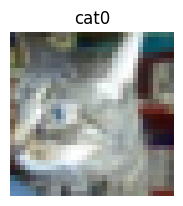

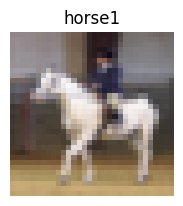

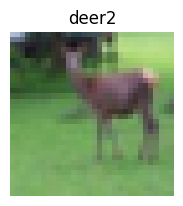

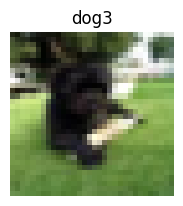

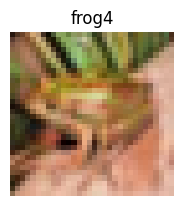

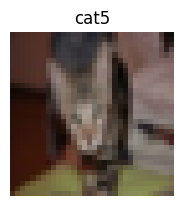

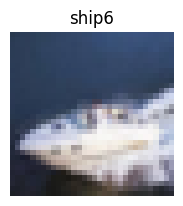

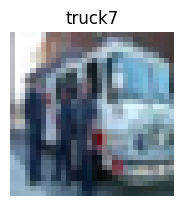

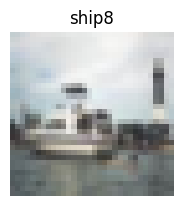

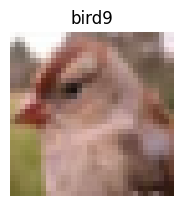

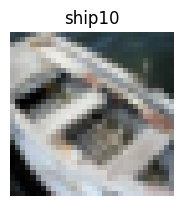

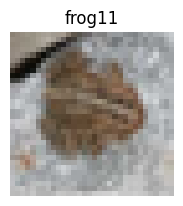

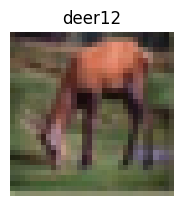

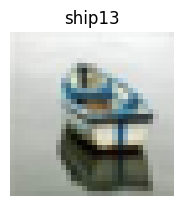

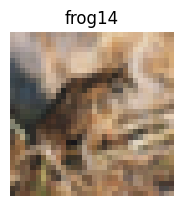

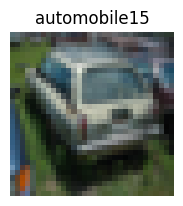

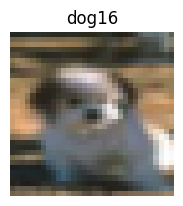

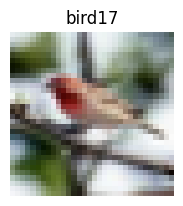

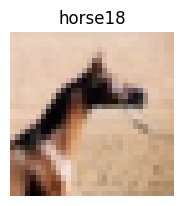

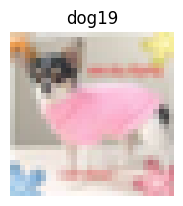

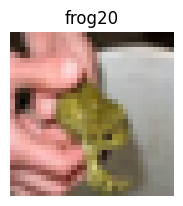

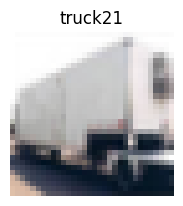

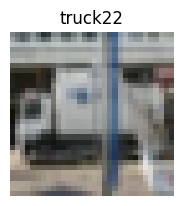

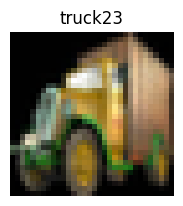

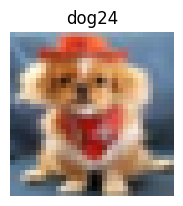

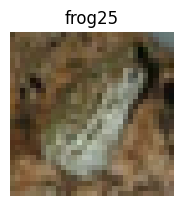

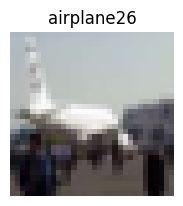

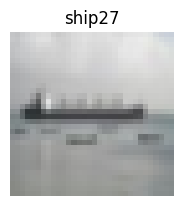

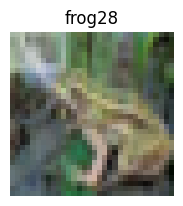

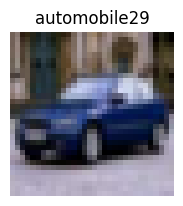

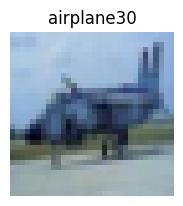

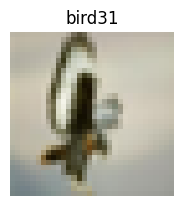

In [7]:
image, label = next(iter(train_dataloader))
image.shape, label.shape
for i in range(32):
    plt.figure(figsize=(20, 20))
    plt.subplot(8, 4, i+1)
    plt.imshow(image[i].permute(1, 2, 0))
    plt.title(class_names[label[i]] + str(i))
    plt.axis('off')
# plt.imshow(image[0].permute(1, 2, 0))
# plt.title(class_names[label[0].item()])
# plt.show()

In [8]:
image[0].permute(1, 2, 0).shape

torch.Size([32, 32, 3])

## Model

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [88]:
torch.manual_seed(42)
class TINYVGG(nn.Module):
    def __init__(self, in_channels, hidden_units, output):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x


model = TINYVGG(in_channels=3, hidden_units=10, output=10).to(device)

# Gives 50% TEST ACCURACY


In [105]:
torch.manual_seed(42)
class TINYVGGMOD(nn.Module):
    def __init__(self, in_channels, hidden_units, output):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.resnetconv = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU()
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
                    nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU(),
                    nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    padding=1,
                    stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=hidden_units*8*8),
            nn.Linear(in_features=hidden_units*8*8, out_features=output)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.resnetconv(x) - x
        x = self.conv_block2(x)
        x = self.resnetconv(x) - x
        x = self.classifier(x)
        return x


model = TINYVGGMOD(in_channels=3, hidden_units=12, output=10).to(device)

In [112]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class TinyResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 16, 2)
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 64, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# # Example usage
# if __name__ == "__main__":
#     model = TinyResNet(num_classes=10)
#     print(model)

#     # Test with a random input
#     x = torch.randn(1, 3, 32, 32)  # Input shape for CIFAR-10
#     output = model(x)
#     print(output.shape)

model = TinyResNet(num_classes=10).to(device)


In [118]:
test_image = torch.randn(3, 32, 32)
test_image2 = torch.randn(32, 32, 3)
test_image.shape
# plt.imshow(test_image)
output = model(test_image.unsqueeze(0).to(device))
output.shape

torch.Size([1, 10])

In [114]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

In [115]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)


        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [116]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [117]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
timeron = timer()

# Train and test model
EPOCHS = 10
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

timeroff = timer()
print(f"Total time taken on {device} : {timeroff-timeron}")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.39333 | Train accuracy: 48.37%
Test loss: 1.54586 | Test accuracy: 44.79%

Epoch: 1
---------
Train loss: nan | Train accuracy: 10.08%
Test loss: nan | Test accuracy: 10.01%

Epoch: 2
---------
Train loss: nan | Train accuracy: 10.00%
Test loss: nan | Test accuracy: 10.01%

Epoch: 3
---------


KeyboardInterrupt: 

In [ ]:
# torch.manual_seed(42)
i = np.random.randint(0, 10)
image, label = next(iter(test_dataloader))
image.shape, label.shape
plt.imshow(image[i].permute(1, 2, 0))
plt.title(class_names[label[i].item()])
plt.show()


output = model(image[i].unsqueeze(0).to(device))
print(f"The Model Predicted This Image As : {class_names[torch.argmax(output, dim=1)]}")

## THIS CODE IS STILL IN PROGRESS